In [8]:
import json
import skimage.transform
import numpy as np
import pandas as pd
import sklearn.cross_validation

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

import os
import pickle

In [2]:
# training images resized to 640x640 (preserving aspect ratio, black background, centered vertically)
DATA_DIR = '../Kaggle-Whales-Caffe/data/train320'

# original training images
ORIG_DATA_DIR = '../Kaggle-Whales-Caffe/data/train'

In [3]:
d = pickle.load(open('train320data.pkl'))
fns = d['filenames']
p1ts = d['point1']
p2ts = d['point2']

In [27]:
SEED = 1

np.random.seed(SEED)

train_ix, val_ix = sklearn.cross_validation.train_test_split(np.arange(len(fns)), test_size=0.2)

In [25]:
# generate batch of images and blowhole masks

def batch(ix, N, seed):
    X = np.zeros((N, 3, 320, 320)).astype('float32')
    Mask = np.zeros((N, 2, 320, 320)).astype('float32')
    
    rng = np.random.RandomState(seed)
    ix = ix[rng.randint(0, len(ix), N)]
    for n, i in enumerate(ix):
        fn = fns[i]

        im = plt.imread('{}/{}'.format(DATA_DIR, fn))
        im = im/255. - 0.5
        mask = np.zeros(im.shape[:2])

        x1, y1 = p1ts[i]
        x1 = int(x1)
        y1 = int(y1)
        try:
            mask[y1, x1] = 1
        except IndexError:
            pass

        Mask[n, 0] = mask

        mask = np.zeros(im.shape[:2])
        x1, y1 = p2ts[i]
        x1 = int(x1)
        y1 = int(y1)
        try:
            mask[y1, x1] = 1
        except IndexError:
            pass
        
        
        Mask[n, 1] = mask
        X[n] = im.transpose(2, 0, 1)
    return X, Mask

In [13]:
import lasagne
import theano
import theano.tensor as T

from lasagne.layers import InputLayer
from lasagne.layers.dnn import Conv2DDNNLayer as Conv
from lasagne.layers.dnn import Pool2DDNNLayer as Pool
from lasagne.layers import Upscale2DLayer
from lasagne.layers import ConcatLayer

from lasagne.nonlinearities import softmax

Using gpu device 0: GeForce GTX 770 (CNMeM is disabled)


In [14]:
# Based on Recombinator Network from http://arxiv.org/abs/1511.07356

def build_net(IMAGE_W):
    net = {}
    l = InputLayer((None, 3, IMAGE_W, IMAGE_W))
    net['input'] = l

    l = Conv(l, 16, 3, pad='same')
    net['T4'] = l

    l = Conv(Pool(l, 2), 32, 3, pad='same')
    net['T3'] = l

    l = Conv(Pool(l, 2), 48, 3, pad='same')
    net['T2'] = l

    l = Conv(Pool(l, 2), 48, 3, pad='same')
    net['T1'] = l

    l = Conv(Conv(net['T1'], 48, 3, pad='same'), 48, 3, pad='same')
    l = Upscale2DLayer(l, 2)
    net['M1'] = l

    l = ConcatLayer((net['T2'], net['M1']))
    l = Conv(Conv(l, 48, 3, pad='same'), 32, 3, pad='same')
    l = Upscale2DLayer(l, 2)
    net['M2'] = l

    l = ConcatLayer((net['T3'], net['M2']))
    l = Conv(Conv(l, 32, 3, pad='same'), 16, 3, pad='same')
    l = Upscale2DLayer(l, 2)
    net['M3'] = l

    l = ConcatLayer((net['T4'], net['M3']))
    l = Conv(Conv(l, 16, 3, pad='same'), 2, 3, pad='same', nonlinearity=None)
    
    l = lasagne.layers.ReshapeLayer(l, (-1, IMAGE_W*IMAGE_W))
    l = lasagne.layers.NonlinearityLayer(l, softmax)
    l = lasagne.layers.ReshapeLayer(l, (-1, 2, IMAGE_W, IMAGE_W))
    net['M4'] = l

    return net

In [47]:
IMAGE_W = 320

lasagne.random.set_rng(np.random.RandomState(SEED))

net = build_net(IMAGE_W)
pv0 = lasagne.layers.get_all_param_values(net['M4'])

In [48]:
X = T.tensor4()
Y = T.tensor4()
output = lasagne.layers.get_output(net['M4'], X)

loss = lasagne.objectives.binary_crossentropy(output.reshape((-1, IMAGE_W*IMAGE_W)),
                                              Y.reshape((-1, IMAGE_W*IMAGE_W))
                                             )
loss = T.mean(loss)

params = lasagne.layers.get_all_params(net['M4'])

LR = theano.shared(np.array(0.0001).astype('float32'))
updates = lasagne.updates.adam(loss, params, learning_rate=LR)

In [49]:
f_predict = theano.function([X], output)
f_train = theano.function([X, Y], loss, updates=updates)
f_val = theano.function([X, Y], [loss, output])

In [50]:
def maxloc(mask):
    a = mask.reshape((-1, IMAGE_W*IMAGE_W)).argmax(-1)
    y = a % IMAGE_W
    x = a // IMAGE_W
    return np.array((y, x)).T

def l2dist(x1, x2):
    return np.sqrt(((x1 - x2)**2).sum(-1))

In [52]:
rng = np.random.RandomState(SEED)

for epoch in range(100):
    train_loss = 0
    for _ in range(10):
        Xb, Mb = batch(train_ix, 24, rng.randint(4294967295))
        train_loss += f_train(Xb, Mb)
    train_loss /= 10
    val_dist = []
    val_loss = 0
    for _ in range(10):
        Xb, Mb = batch(val_ix, 24, rng.randint(4294967295))
        loss, Pb = f_val(Xb, Mb)
        val_loss += loss
        val_dist.append(l2dist(maxloc(Mb), maxloc(Pb)))
    val_dist = np.concatenate(val_dist)
    val_loss /= 10
    print('Epoch {:03}: loss train (val) {:.07f} ({:.07f}) mean dist {:.01f}, nearby {:.03f}'.format(
            epoch, train_loss, val_loss, val_dist.mean(), (val_dist < 10).mean()))

Epoch 000: loss train (val) 0.0001223 (0.0001222) mean dist 70.7, nearby 0.073
Epoch 001: loss train (val) 0.0001221 (0.0001221) mean dist 62.5, nearby 0.104
Epoch 002: loss train (val) 0.0001220 (0.0001219) mean dist 64.2, nearby 0.083
Epoch 003: loss train (val) 0.0001218 (0.0001218) mean dist 65.6, nearby 0.083
Epoch 004: loss train (val) 0.0001215 (0.0001214) mean dist 65.2, nearby 0.077
Epoch 005: loss train (val) 0.0001212 (0.0001210) mean dist 63.5, nearby 0.098
Epoch 006: loss train (val) 0.0001208 (0.0001204) mean dist 59.4, nearby 0.106
Epoch 007: loss train (val) 0.0001199 (0.0001193) mean dist 60.4, nearby 0.117
Epoch 008: loss train (val) 0.0001186 (0.0001176) mean dist 58.0, nearby 0.115
Epoch 009: loss train (val) 0.0001154 (0.0001136) mean dist 56.9, nearby 0.125
Epoch 010: loss train (val) 0.0001123 (0.0001106) mean dist 63.2, nearby 0.102
Epoch 011: loss train (val) 0.0001079 (0.0001071) mean dist 62.3, nearby 0.117
Epoch 012: loss train (val) 0.0001045 (0.0001022) me

In [70]:
#pvt = lasagne.layers.get_all_param_values(net['M4'])
#pickle.dump(pvt, open('loc2_seed1_trained_100epoch.pkl', 'w'))

pvt = pickle.load(open('loc2_seed1_trained_100epoch.pkl'))
lasagne.layers.set_all_param_values(net['M4'], pvt)

In [71]:
# try predicting on test image
im = plt.imread('../Kaggle-Whales-Caffe/data/test/w_10006.jpg')

im = skimage.transform.resize(im, (im.shape[0]*320/im.shape[1], 320))
a = (320 - im.shape[0]) // 2 + 1
im = np.pad(im, [(a, a), (0, 0), (0, 0)], mode='constant', constant_values=0.5)
im = im[:320, :320].transpose(2, 0, 1)[np.newaxis] - 0.5

In [72]:
im.shape

(1, 3, 320, 320)

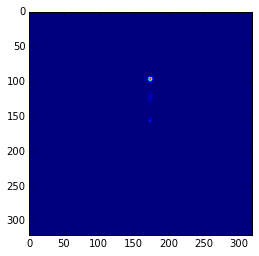

In [73]:
p = f_predict(im.astype('float32'))
p /= p.max()
plt.imshow(p[0,0])

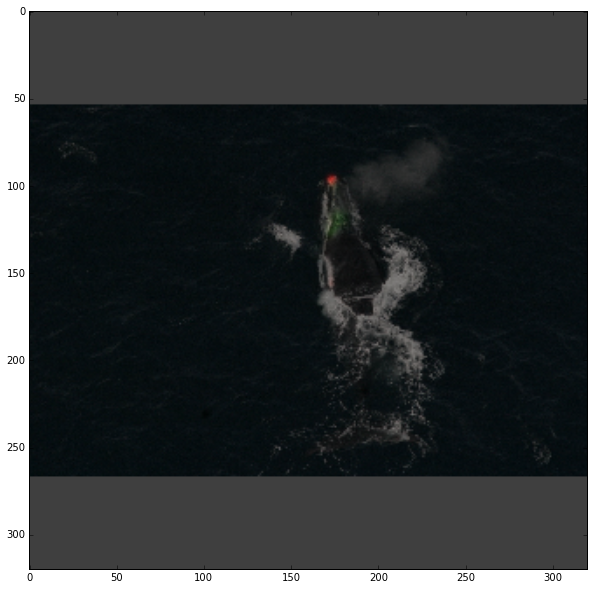

In [74]:
# it works!

plt.figure(figsize=(10, 10))
a = 0.5*(im[0].transpose(1,2,0)+0.5) + 0.5*p[0,0][:,:,np.newaxis]*[1,0,0] + 0.5*p[0,1][:,:,np.newaxis]*[0,1,0]
plt.imshow(a)

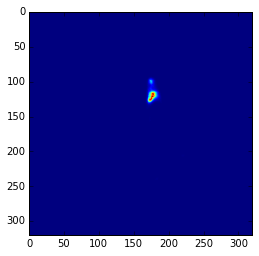

In [68]:
p = f_predict(im.astype('float32'))
p /= p.max()
plt.imshow(p[0,1])

In [75]:
# Load training annotations

points1 = json.load(open('../Kaggle-Whales-Caffe/points1.json'))
points2 = json.load(open('../Kaggle-Whales-Caffe/points2.json'))

p1s = np.array([(p['annotations'][0]['x'], p['annotations'][0]['y']) for p in points1])
p2s = np.array([(p['annotations'][0]['x'], p['annotations'][0]['y']) for p in points2])
fns = np.array([p['filename'] for p in points1])

In [92]:
s = p1s[:,0] / p1ts[:,0]
t = p1s[:,1] - p1ts[:,1]*s

In [96]:
net = build_net(IMAGE_W)

pvt = pickle.load(open('loc2_seed1_trained_100epoch.pkl'))
lasagne.layers.set_all_param_values(net['M4'], pvt)

X = T.tensor4()
Y = T.tensor4()
output = lasagne.layers.get_output(net['M4'], X)

f_predict = theano.function([X], output)

In [127]:
cd ../../kaggle-whale/

/home/eben/projects/whale/kaggle-whale


In [171]:
TEST_DATA_DIR = './data/test320/'
ORIG_DATA_DIR = './data/test/'

In [193]:
i = 30

im = np.array(Image.open('{}/{}'.format(TEST_DATA_DIR, fns[i])))
im0 = Image.open('{}/{}'.format(ORIG_DATA_DIR, fns[i]))
im1 = skimage.transform.resize(np.array(im0), (384, 384))

im = im/255. - 0.5
im = im.transpose(2, 0, 1)[np.newaxis]
im = im.astype('float32')

ps = maxloc(f_predict(im))

s = im0.size[0] / 320.
t = (320 - im0.size[1] / s) / 2.
ps[:,1] = ps[:,1] - t
ps = ps * s

ps = ps * (384, 384)/im0.size[:2]

In [194]:
im0.size

(5275, 3517)

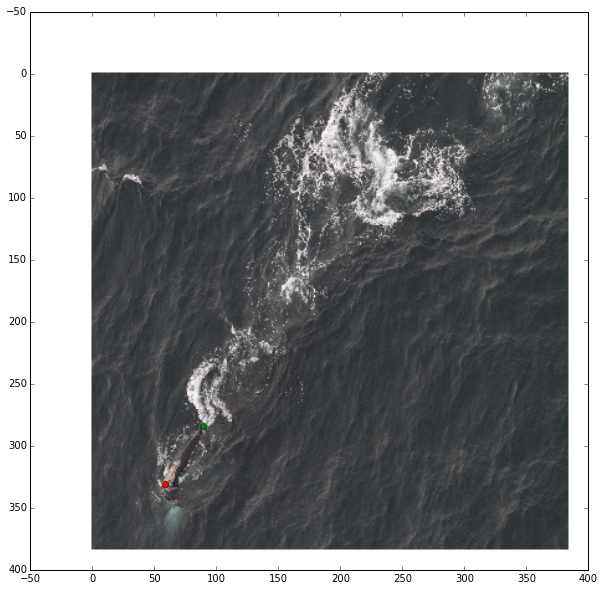

In [195]:
plt.figure(figsize=(10,10))
plt.imshow(im1)

x1, y1 = ps[0]
plt.plot([x1,], [y1,], 'ro')

x1, y1 = ps[1]
plt.plot([x1,], [y1,], 'go')


In [168]:
TEST_DATA_DIR = './data/test320/'
ORIG_DATA_DIR = './data/test/'

In [196]:
d = {}
for i in range(len(fns)):
    im = np.array(Image.open('{}/{}'.format(TEST_DATA_DIR, fns[i])))
    im0 = Image.open('{}/{}'.format(ORIG_DATA_DIR, fns[i]))

    im = im/255. - 0.5
    im = im.transpose(2, 0, 1)[np.newaxis]
    im = im.astype('float32')

    ps = maxloc(f_predict(im))

    s = im0.size[0] / 320.
    t = (320 - im0.size[1] / s) / 2.
    ps[:,1] = ps[:,1] - t
    ps = ps * s
    ps = ps * (384, 384)/im0.size[:2]

    d[fns[i]] = ps

In [212]:
testpoints = json.load(open('./testpoints/testpoints1_filtered.json'))

for p in testpoints:
    x, y = d[p['filename']][0]
    p['annotations'][0]['x'] = int(x)
    p['annotations'][0]['y'] = int(y)
    
json.dump(testpoints, open('./testpoints/lasagne_loc_seed_1_point1.json','w'), indent=0)    

testpoints = json.load(open('./testpoints/testpoints2_filtered.json'))
for p in testpoints:
    x, y = d[p['filename']][1]
    p['annotations'][0]['x'] = int(x)
    p['annotations'][0]['y'] = int(y)
    
json.dump(testpoints, open('./testpoints/lasagne_loc_seed_1_point2.json','w'), indent=0)    